# Mask detection project

### Prepared by Emma Millot, Margaux Boscary, Walid YASSINE, Karim KASSAB


Introduction, motivation

Description of the task

2 steps:
- Face Detection
> Explain MTCNN
- Face classification

https://susanqq.github.io/UTKFace/

Talk about the complementary dataset

# Importing Librarires

In [216]:
!pip install mtcnn
!pip install bing_image_downloader
!pip install keras_retinanet

import sys
import os
import shutil
import glob
import numpy as np
import xml.etree.ElementTree as ETree
import cv2
import matplotlib.pyplot as plt
from keras_retinanet.utils.image import read_image_bgr
import random
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML, display, Javascript
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from bing_image_downloader import downloader
from tqdm import tqdm
from google.colab.output import eval_js
from base64 import b64decode

     |████████████████████████████████| 71 kB 6.4 MB/s 
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=164343 sha256=8db32ebcfbc92c1b3d7c4898a3560b71953395c677a223ae89fbf3e86879f674
  Stored in directory: /root/.cache/pip/wheels/55/a1/41/f2dbc08b26549fe00041b9bc25c299f262b0311ad68cc52522
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=5aa3734b2cd8d438756b0a694d3ecad50b697dd342f09affea3db276c481bf71
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-retinanet keras-resnet


### Metafunctions to be used in the notebook

In [2]:
# To display images in the center of the notebook
def center():
  display(HTML("""
  <style>
  #output-body {
      display: flex;
      align-items: center;
      justify-content: center;
  }
  </style>
  """))
  return

In [ ]:
# Function to take photo from camera
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

### Importing data

In [322]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/mask_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/mask_data


In [4]:
# shutil.unpack_archive('archive.zip')
print('Number of annotations found:', len(glob.glob('annotations' + '*/*')))
print('Number of images found:', len(glob.glob('images' + '*/*')))

Number of annotations found: 853
Number of images found: 853


### Data Preparation

Defining general variables to be used in the notebook

In [5]:
img_size = (100, 100)
confidence_threshold = 0.88
label_name = {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}
name_label = {0 : 'without_mask', 1 : 'with_mask', 2 : 'mask_weared_incorrect'}
annotation_path = 'annotations'
img_path = 'images'
nb_classes = len(label_name)

#### Annotation extraction

In [6]:
def read_from_XML(annotation_path=annotation_path, img_path=img_path):
  '''
    Function to read from XML files

    annotation_path: str
      Path to the annotation files

    img_path: str
      Path to the image files

    Returns:

    dataset: list
      List of dictionnaries of annotations for each image
      containing the path of the image and the information
      of the objects given by a list of 5 numbers representing
      the label and the coordinates of the bounding boxes
  '''
  dataset = []
  # Looping over all the files in our directory
  for root, dirs, files in sorted(os.walk(annotation_path)):
      for file in sorted(files):
          # Reading the structure of the XML file
          tree = ETree.parse(os.path.join(root, file))
          # The annotations file from Kaggle has two fields:
          # Filename: The name of the image
          # Objects: List of detected faces
          data = {'path': None, 'objects': []}
          data['path'] = os.path.join(img_path, tree.find('filename').text)
          for obj in tree.findall('object'):
              label = label_name[obj.find('name').text]

              # Getting the bounding box coordinates
              xmin = int(obj.find('bndbox/xmin').text)
              ymin = int(obj.find('bndbox/ymin').text)
              xmax = int(obj.find('bndbox/xmax').text)
              ymax = int(obj.find('bndbox/ymax').text)
              
              # Appending to data
              data['objects'].append([label, xmin, ymin, xmax, ymax])
          dataset.append(data)
  print(f'Successfully read {len(dataset)} images')
  return dataset

In [7]:
dataset = read_from_XML(annotation_path ,img_path)

Successfully read 853 images


#### Face detection

Introduction, MTCNN, etc

In this section, we apply the MTCNN face detection model and compare it with the ground truh faces.
<br>This will give us an idea about the confidence threshold we need to set, to avoid false detections.
<br><br><font color='red'>Note:</font> 
The OpenCV library reads the images in a BGR format by default. It is necessary to take this into account when we want to build our model.

In [8]:
def get_face_detection(img_idx, confidence_threshold=0.88):
  """Return image with a bounding box on detected faces

  Parameters
  ----------
  img_idx : int
      The index of the image in the dataset
  confidence_threshold: float
      The threshold above which the detection is considered.
  Returns
  -------
  bgr_image : ndarray, shape (h,w)
      The input image with a bounding box on detected faces
  """
  imagePath = dataset[img_idx]['path']
  face_detector = MTCNN()
  bgr_image = cv2.imread(imagePath)
  rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
  faces = face_detector.detect_faces(rgb_image)
  

  for face in faces:
    try:
      # Getting the coordinates of the bounding box
      x, y, w, h = face['box']
      confidence = face['confidence']
      
      # Skipping the detected faces with low confidence
      if confidence < confidence_threshold:
        continue

      # Getting the patch and resizing
      patch_roi =  rgb_image[y : y+h, x : x+w]
      img = cv2.resize(patch_roi, img_size)
      bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      # cv2_imshow(bgr_img)

      # Draw bounding boxes
      cv2.rectangle(bgr_image, (x, y), (x+w, y+h), color=(0,0,255), thickness=2)
      text = "{: .2f}".format(confidence)
      cv2.putText(bgr_image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
      
    except Exception as e:
      print(e)
      print(patch_roi.shape)

  # Return the frame
  return bgr_image
  

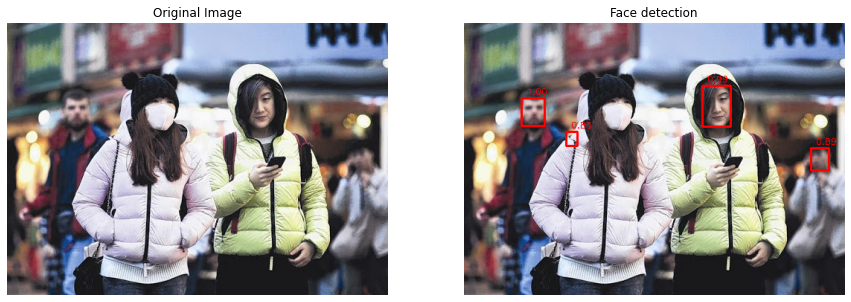

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
center()

img_idx = 0

# Original image
imagePath = dataset[img_idx]['path']
original_img = cv2.imread(imagePath)

# Starting with a low confidence threshold
detected_image = get_face_detection(img_idx=img_idx, confidence_threshold=0.8)

axs[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title("Original Image")

axs[1].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title("Face detection")

plt.show()

<font color='darkblue'><h3><b>Intuition</b></h3></font>
<br>We started the face detection with a confidence threshold of 0.8. We can notice that some detections that are not really faces are invoking the MTCNN model. For example, the shoulder of the woman above in pink.
<br>As a result, we tried to manually tune the confidence threshold for the model, in order to avoid such "false positives", and at the same time, to be able to detect faces and avoid "false negatives".

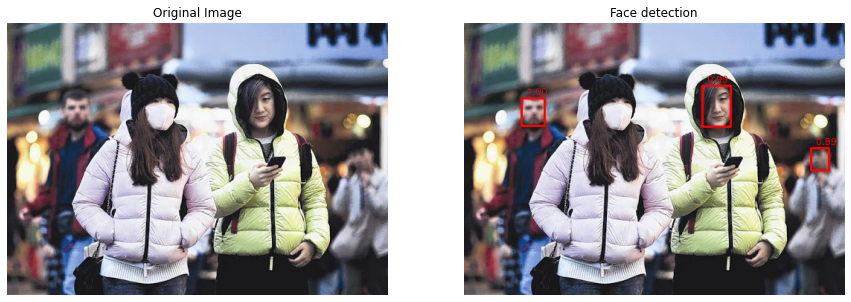

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
center()

img_idx = 0

# Original image
imagePath = dataset[img_idx]['path']
original_img = cv2.imread(imagePath)

# Starting with a low confidence threshold
detected_image = get_face_detection(img_idx=img_idx, confidence_threshold=0.88)

axs[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title("Original Image")

axs[1].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title("Face detection")

plt.show()

After testing the confidence threshold on multiple values and on multiple images, we noticed that the value **0.88** is a good compromise between undetected faces and falsely detected faces.
<br>**Indeed**, in some cases, we might still get some confusing detected faces (for instance, the blurry "face" on the right). However, we're not working in an ideal context, so it's acceptable to have very low numbers of such confusing examples.

In [12]:
# Setting the confidence threshold
confidence_threshold = 0.88

Another point worth mentioning is that the MTCNN model was not able to detect the face of the woman in pink because her head is very obstructed (by a big mask and by a big hat).
<br>At first sight, one might think that the MCNN model may not be able to detect faces with masks. Let's explore a bit more to verify the robustness of MTCNN towards obstructed faces.

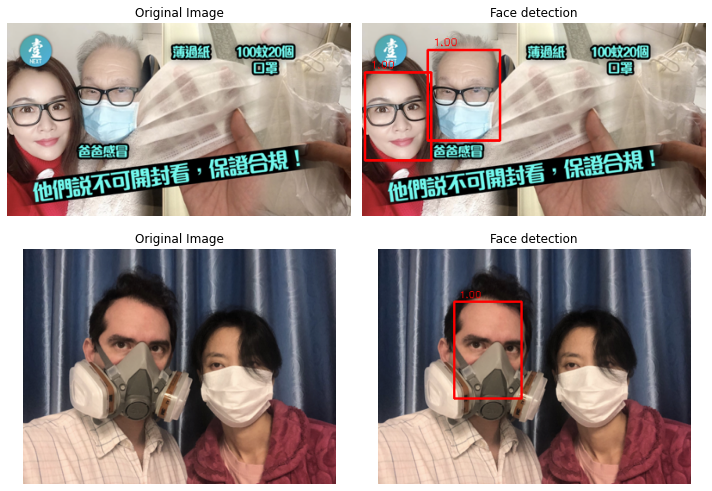

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
center()

img_idx1 = 18
img_idx2 = 28

# -----------------------   Image 1   -----------------------
# Original image
imagePath = dataset[img_idx1]['path']
original_img = cv2.imread(imagePath)

# Starting with a low confidence threshold
detected_image = get_face_detection(img_idx=img_idx1, confidence_threshold=confidence_threshold)

axs[0,0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axs[0,0].axis('off')
axs[0,0].set_title("Original Image")

axs[0,1].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
axs[0,1].axis('off')
axs[0,1].set_title("Face detection")

# -----------------------   Image 2   -----------------------

# Original image
imagePath = dataset[img_idx2]['path']
original_img = cv2.imread(imagePath)

# Starting with a low confidence threshold
detected_image = get_face_detection(img_idx=img_idx2, confidence_threshold=confidence_threshold)

axs[1,0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axs[1,0].axis('off')
axs[1,0].set_title("Original Image")

axs[1,1].imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
axs[1,1].axis('off')
axs[1,1].set_title("Face detection")

plt.tight_layout()
plt.show()

Clearly, the MTCNN model is able to detect faces with masks on with high confidence even with weird looking masks.
<br>The case we saw at the beginning with the undetected woman face is such a particular case because her face and her entire head is obstructed, rendering the MTCNN model unable to detect her masked face.
<br>We can also notice that the face on the bottom right has a confidence value equal to the exact threshold that we decided on. This is due to the fact that half her forehead is covered by her hair. So, her face is not detected with relatively high confidence.



<font color='darkgreen'>**Conclusion:**</font> Using the MTCNN with a confidence threshold of 0.88 is a good compromise between false positives and false negatives, and to detect faces even with mask on.

### Comparing our face detector to the annotations

In [14]:
def get_ground_truth_img(img_idx):
  """Returns the image with ground truth annotations

  Parameters
  ----------
  img_idx : int
      The index of the image in the dataset
      
  Returns
  -------
  bgr_image : ndarray, shape (h,w)
      The input image with a bounding box on detected faces
  """
  datum = dataset[img_idx]
  img_path = datum['path']
  objects = datum['objects']
  bgr_image = cv2.imread(img_path)
  rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

  for obj in objects:
    # Getting the coordinates of the bounding box
    _, xmin, ymin, xmax, ymax = obj
      
    # Getting the patch and resizing
    patch_roi =  rgb_image[ymin:ymax, xmin:xmax]
    img = cv2.resize(patch_roi, img_size)
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Draw bounding boxes
    cv2.rectangle(bgr_image, (xmin, ymin), (xmax, ymax), color=(0,0,255), thickness=2)

  return bgr_image

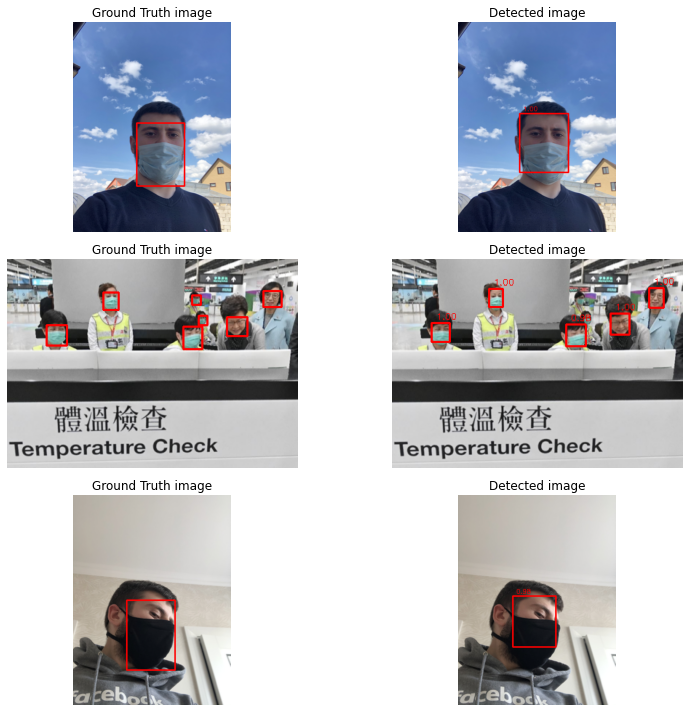

In [15]:
img_idx = [10,23,50]
nb = 3

fig, axs = plt.subplots(nb, 2, figsize=(12,10))
center()

for l in range(nb):
  original_image = get_ground_truth_img(img_idx=img_idx[l])
  original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
  axs[l,0].imshow(original_image)
  axs[l,0].set_title("Ground Truth image")
  axs[l,0].axis('off')

  img = get_face_detection(img_idx=img_idx[l], confidence_threshold=confidence_threshold)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axs[l,1].imshow(img)
  axs[l,1].set_title("Detected image")
  axs[l,1].axis('off')

plt.tight_layout()
plt.show()

We can notice that the detected faces with the MTCNN model are relatively very good. It's even capable to detect small faces when the image has multiple people in it, even if their faces are covered in masks

### Preparing data for model

In [335]:
def get_faces():
  """Gets the original images and 
  the associated ground truth labels
      
  Returns
  -------
  X : ndarray, shape (N,img_size,3)
      List of the detected faces (patches) in RGB
  Y : ndarray, shape (N,nb_classes)
      One hot encoding of the target labels
  """
  X, Y = [], []
  # Looping over all the datapoints in our dataset
  for datum in tqdm(dataset):
    # Reading image from the path
    img = cv2.imread(datum['path'])

    # Looping over all detected faces in an image
    for obj in datum['objects']:
      # Getting the annotations
      label, xmin, ymin, xmax, ymax = obj
      # Cropping and resizing the face
      face = img[ymin : ymax, xmin : xmax]
      face = cv2.resize(face, img_size)
      # Converting the image to RGB to process it well
      # (since the cv reads it in BGR)
      x = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

      # Converting the label to one hot encoding
      y = to_categorical(label, num_classes=nb_classes)

      X.append(x)
      Y.append(y)

  X = np.array(X)
  Y = np.array(Y)
  print(f"\n\nX shape {X.shape}")
  print(f"Y shape {Y.shape}")

  print(f"\nNumber of detected faces: {Y.shape[0]}")
  print(f"Size of each face: {X.shape[1]} x {X.shape[2]} x {X.shape[3]}")

  return X, Y

In [275]:
X, Y = get_faces()

100%|██████████| 853/853 [00:14<00:00, 58.54it/s]




X shape (4072, 100, 100, 3)
Y shape (4072, 3)

Number of detected faces: 4072
Size of each face: 100 x 100 x 3


In [276]:
X_intrinsic = X.copy() # to delete
Y_intrinsic = Y.copy() # to delete

### Scrapping new data

In this part of the project, we decided to do some data scrapping to enrich our dataset with new images of both faces with and without masks
<br>Note that after scrapping, we did some data cleaning and removed images that we found to be irrelevant
<br><b><font color='red'>Remark:</b></font> we only ran this code once, and uploaded the scrapped photos as a .zip file to the drive.

In [18]:
def scrap_images(query_string="faces with mask", nb_images=300):
  """Scraps images from bing
      
  Parameters
  -------
  query_string : str
      String to query in bing
  nb_images : int
      Number of images to download
  """
  downloader.download(query_string, limit=nb_images, output_dir='Images', force_replace=False, timeout=60, verbose=False)

<font color='red'>**Note**:</font>  
<ul><li>We only run the cell below once (the first time we run the notebook) to get the data, and then we save the data in the drive.
 <li>We only did the scrapping of mask and no mask since there are not a lot of relevant data of people wearing masks incorrectly.
 </ul>

In [355]:
def get_scrapped_faces(confidence_threshold=0.88, data_paths={}):
  """Gets the scrapped images and 
  the detected faces

  Parameters
  ----------
  confidence_threshold: float
      The threshold above which the detection is considered.
  data_paths : Dictionary
      Dictionary with the label as the key and the list of paths as the value

  Returns
  -------
  X : ndarray, shape (N,img_size,3)
      List of the detected faces (patches) in RGB
  Y : ndarray, shape (N,nb_classes)
      One hot encoding of the target labels
  """
  # Initialzing face dector
  face_detector = MTCNN()
  X, Y = [], []
  
  # Iterating over the different label groups: Mask and No Mask
  for label, paths in data_paths.items():
    if (label == 0):
      print("Loading faces without masks")
    else:
      print("Loading faces with masks")
    
    # Iterating over the scrapped data
    for imagePath in tqdm(paths):
      bgr_image = cv2.imread(imagePath)
      rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
      faces = face_detector.detect_faces(rgb_image)
    

      for face in faces:
        try:
          # Getting the coordinates of the bounding box
          x, y, w, h = face['box']
          confidence = face['confidence']
          
          # Skipping the detected faces with low confidence
          if confidence < confidence_threshold:
            continue

          # Getting the patch and resizing
          patch_roi =  rgb_image[y : y+h, x : x+w]
          img = cv2.resize(patch_roi, img_size)

          # Converting label to one hot encoding
          l = to_categorical(label, num_classes=nb_classes)

          X.append(img)
          Y.append(l)
      
        except Exception as e:
          print(e)
          print(patch_roi.shape)
    
  X, Y = np.array(X), np.array(Y)

  print(f"\n\nX_scrapped shape {X.shape}")
  print(f"Y_scrapped shape {Y.shape}")

  print(f"\nNumber of detected faces from the scrapped data: {Y.shape[0]}")
  print(f"Size of each face: {X.shape[1]} x {X.shape[2]} x {X.shape[3]}")
  return X, Y

In [19]:
# scrap_images(query_string="faces", nb_images=300)
# scrap_images(query_string="faces with mask", nb_images=300)

In [20]:
# shutil.unpack_archive('extended_dataset.zip')
scrapped_mask_paths = glob.glob('extended_dataset/mask*/*')
scrapped_no_mask_paths = glob.glob('extended_dataset/no_mask*/*')
print('Number of images with mask scrapped:', len(scrapped_mask_paths))
print('Number of images with no mask scrapped:', len(scrapped_no_mask_paths))

Number of images with mask scrapped: 173
Number of images with no mask scrapped: 210


In [21]:
scrapped_data_paths = {0: scrapped_no_mask_paths, 1: scrapped_mask_paths}

In [23]:
X_scrapped, Y_scrapped = get_scrapped_faces(confidence_threshold=confidence_threshold, data_paths=scrapped_data_paths)

Loading faces without masks


100%|██████████| 210/210 [02:34<00:00,  1.36it/s]


Loading faces with masks


100%|██████████| 173/173 [06:11<00:00,  2.15s/it]



X_scrapped shape (416, 100, 100, 3)
Y_scrapped shape (416, 3)

Number of detected faces from the scrapped data: 416
Size of each face: 100 x 100 x 3


### Displaying some randomly chosen faces from the scrapped dataset.

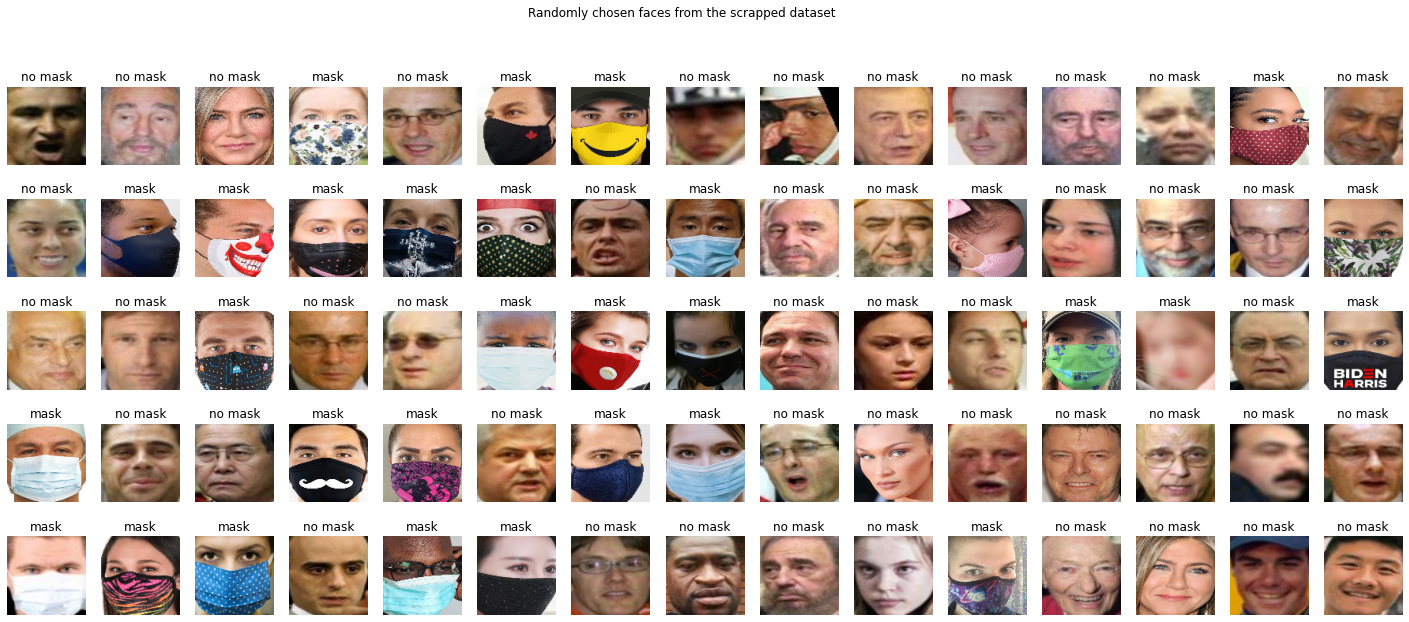

In [24]:
center()
render_size = [5, 15]
figsize = (25,10)

fig, axs = plt.subplots(render_size[0], render_size[1], figsize=figsize)
idx = np.array(random.sample(range(0,X_scrapped.shape[0]), render_size[0]*render_size[1])).reshape(render_size[0], render_size[1])
subtitles = {0 : 'no mask', 1 : 'mask', 2 : 'misplaced'}

for i in range(render_size[0]):
    for j in range(render_size[1]):
        axs[i,j].imshow(X_scrapped[idx[i,j]])
        axs[i,j].axis('off')
        label = subtitles[np.argmax(Y_scrapped[idx[i,j]])]
        axs[i,j].set_title(label)


plt.suptitle("Randomly chosen faces from the scrapped dataset")
plt.show()

### Data normalization and preprocessing

In [25]:
# # Normalizing
# img = img / 255.

# # Adding a dimension for the batch size
# # To delete... img = img.reshape((1,) + img.shape)
# img = img[None, :, :]

In [26]:
# VISUALIZATION OF THE CLASSES PROPORTIONS

### Visualization of the class proportions

In this section, we will check the proportions of the classes in our dataset so far.

In [277]:
X = np.append(X, X_scrapped, axis=0)
Y = np.append(Y, Y_scrapped, axis=0)
y = np.argmax(Y, axis=1)

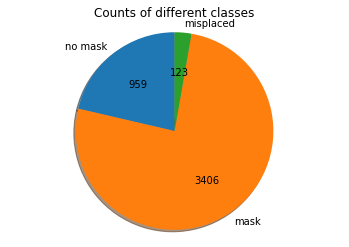

In [301]:
_, class_counts = np.unique(y, axis=0, return_counts=True)

def absolute_value(val):
    a  = np.round(val/100.*class_counts.sum(), 0)
    return int(a)

fig1, ax1 = plt.subplots()
center()

labels = list(subtitles.values())
ax1.pie(class_counts, labels=labels, autopct=absolute_value,
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Counts of different classes")

plt.show()

As we can see, there is a big imbalance in the dataset. We can notice that the faces with masks form approximately 70% of the dataset, whereas the proprtion of the images in which the mask is incorrectly placed is very low.
<br>This might create a problem in our model. The model will favor some classes over others.
<br>Clearly, the scrapping that we did is not sufficient since we have a huge imbalance in the dataset.
<br>To overcome this, there are two possible approaches:
<ul>
<li>In the case where we only have access to this particular dataset, we can use stratifies cross validation to make sure that the model is trained on folds with balanced proportions of the classes.
<li>The second approach involves finding more images to balance the dataset. This can be done by doing more scrapping. However, since the imbalance is huge, and since we need to manually monitor the scrapped images to make sure that they're relevant, it would not be practical to do this. Therefore, we decided to augment to our dataset using a new dataset <a href="https://susanqq.github.io/UTKFace/">UTKFace</a>. This dataset only contains faces without masks. We will see how we augment the misplaced class in the next section.
<br>Note that this is a huge dataset, so we'll only use enough data to balance our classes.
</ul>




In [354]:
# shutil.unpack_archive('data_to_add.zip')
print('Number of images without mask loaded:', len(glob.glob('data_to_add/no_mask' + '/*')))
print('Number of images where a mask should be placed (incorrectly) loaded:', len(glob.glob('data_to_add/no_mask_misplaced' + '/*')))

Number of images without mask loaded: 2447
Number of images where a mask should be placed (incorrectly) loaded: 3281


### Loading the additional faces for the class without mask

<h1><font color='red'>DO NOT RUN!!!!!</font></h1>

In [356]:
# Loading the mask dataset
loaded_no_mask_paths = glob.glob('data_to_add/no_mask/*')
loaded_data_paths = {0: loaded_no_mask_paths}
X_loaded_no_mask, Y_loaded_no_mask= get_scrapped_faces(confidence_threshold=confidence_threshold, data_paths=loaded_data_paths)

Loading faces without masks


100%|██████████| 2447/2447 [44:04<00:00,  1.08s/it]



X_scrapped shape (2702, 100, 100, 3)
Y_scrapped shape (2702, 3)

Number of detected faces from the scrapped data: 2702
Size of each face: 100 x 100 x 3


<font color='red'>Note:</font> Since we're loading a big number of images, the process takes a considerable amount of time. To avoid doing this again, we save the numpy arrays to a .npy file on the drive, and then we load it whenever needed.

In [ ]:
# Defning the filenames
filename_X_loaded_no_mask = 'saved_numpy_data/X_loaded_no_mask.npy'
filename_Y_loaded_no_mask = 'saved_numpy_data/Y_loaded_no_mask.npy'

The below cell will be run only once

In [357]:
# # Saving the loaded images and the targets
# np.save(filename_X_loaded_no_mask, X_loaded_no_mask)
# np.save(filename_Y_loaded_no_mask, Y_loaded_no_mask)

In [358]:
X_loaded_no_mask = np.load(filename_X_loaded_no_mask)
Y_loaded_no_mask = np.load(filename_Y_loaded_no_mask)

### Data augmentation: Adding images to the class of misplaced masks

In order to overcome the problem of imbalancing the data, we first thought about scrapping images of people wearing masks incorretly. However, a quick google search of such query gives us irrelevant results (cartoons, people wearing masks correctly, etc). So, it would be irrational to scrap a huge amount of data just to end up with a couple of correctly labeled images after manual cleaning (too time consuming).
<br>Therefore, we decided to create our own augmented dataset of people wearing masks incorrectly. To do this, we will take advantage of the MTCNN model that we're using to detect faces since returns not only the bounding box and the confidence level, but also the keypoints of each detected face.
<br>
<br>Consequently, we will proceed in the following steps:

<ul>
<li> Get images of normal faces not wearing masks
<li>Detect faces on the image
<li>For each face: 

<ul>
<li>Extract the essential keypoints as returned by the MTCNN model: 
<ol>
<li>Left eye
<li>Right eye
<li>Nose
<li>Mouth right
<li>Mouth left
</ol>
<li>Generate other keypoints using geometric projections and transformations. These points will be useful in order to place the mask in the intended position.
<ol>
<li>Forehead point: Projection of the nose on the eyes axis
<li>Middle point: Geometric center of the mask
<li>Angle of rotation: Calculated using the orientation of the nose axis
<li>Gazing ratio: Calculated using the eye to forehead ratios to account for the person not looking directly at the camera.
</ol>
<li>Resize, rotate and proportionize the mask accordingly
<li>Place the mask on the detected face
</ul>
<li>Proceed in the same manner as before:
<ol>
<li>Crop detected face
<li>Resize to default patch size
<li>One hot encode the target
<li>Add to dataset
</ul>





<br>
<font color='red'><b>Note: </b></font>
<br>It's important to not use the same faces that we already used in the dataset (for the people labeled without masks). Otherwise, we would have a high correlation between the classes, and the model won't be able to generalize

## Demonstration of the processing pipeline on an image of Zendaya

### Extraction the keypoints

In [241]:
# Getting the images
img_zendaya = cv2.imread('extended_dataset/misplaced/zendaya.png')
img_zendaya = cv2.cvtColor(img_zendaya, cv2.COLOR_BGR2RGB)
img_zendaya_intrinsic = img_zendaya.copy()

In [242]:
def point_on_line(a, b, p):
  """Computes the coordinates of the projection of p on the line ab

  Parameters
  ----------
  a : ndarray, shape (2,)
      First point.
  b : ndarray, shape (2,)
      Second point.
  p : ndarray, shape (2,)
      Point to project

  Returns
  -------
  projection : ndarray, shape (2,)
      The projected point
  """
  ap = p - a
  ab = b - a
  projection = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
  projection = projection.astype('int')

  return projection

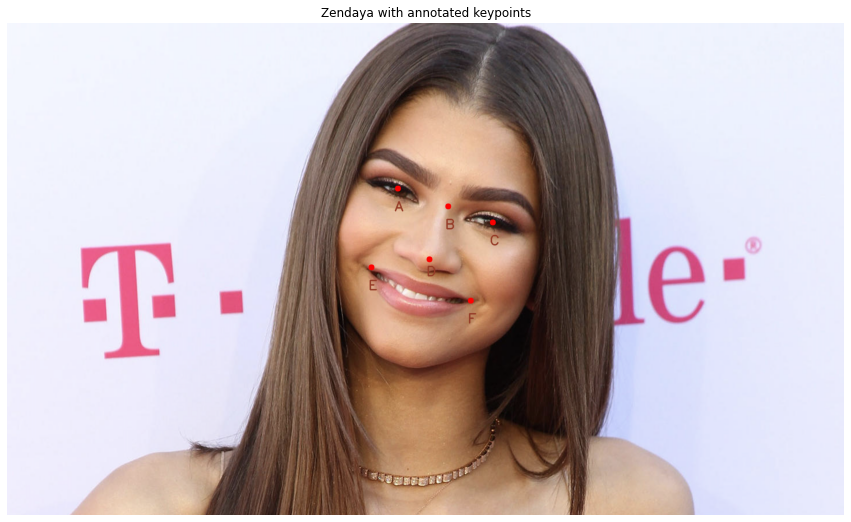

In [243]:
# Detecting features
face_detector = MTCNN()
faces = face_detector.detect_faces(img_zendaya)
for face in faces:
  x, y, w, h = face['box']
  keypoints = face['keypoints']

# Getting the keypoints
nose = np.array(keypoints['nose'])
mouth_left = np.array(keypoints['mouth_left'])
mouth_right = np.array(keypoints['mouth_right'])
left_eye = np.array(keypoints['left_eye'])
right_eye = np.array(keypoints['right_eye'])
forehead = point_on_line(left_eye, right_eye, nose)

# Drawing the keypoints
cv2.circle(img_zendaya, (nose[0], nose[1]), radius=10, color=(255,0,0), thickness=-1)
cv2.circle(img_zendaya, (mouth_left[0], mouth_left[1]), radius=10, color=(255,0,0), thickness=-1)
cv2.circle(img_zendaya, (mouth_right[0], mouth_right[1]), radius=10, color=(255,0,0), thickness=-1)
cv2.circle(img_zendaya, (left_eye[0], left_eye[1]), radius=10, color=(255,0,0), thickness=-1)
cv2.circle(img_zendaya, (right_eye[0], right_eye[1]), radius=10, color=(255,0,0), thickness=-1)
cv2.circle(img_zendaya, (forehead[0], forehead[1]), radius=10, color=(255,0,0), thickness=-1)

# Annotating the keypoints
cv2.putText(img_zendaya, "A", (left_eye[0]-10, left_eye[1]+75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)
cv2.putText(img_zendaya, "B", (forehead[0]-10, forehead[1]+75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)
cv2.putText(img_zendaya, "C", (right_eye[0]-10, right_eye[1]+75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)
cv2.putText(img_zendaya, "D", (nose[0]-10, nose[1]+55), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)
cv2.putText(img_zendaya, "E", (mouth_left[0]-10, mouth_left[1]+75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)
cv2.putText(img_zendaya, "F", (mouth_right[0]-10, mouth_right[1]+75), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (150, 60, 40), 3)

# Plotting
center()
plt.figure(figsize=(15,15))
plt.imshow(img_zendaya)
plt.axis('off')
plt.title("Zendaya with annotated keypoints")
plt.show()

As we can see, we have 7 feature points that we're going to use to be able to correctly place the mask on the image. We will take advantage of these points in different ways in order to compute features that will give us the right area, height, width, position, rotation, and proprotions of the mask.

## The mask

<ul>
<li><b>Size of the mask</b>
<ul>
<li><b><i>Area of the mask</b></i>
<br>Generally, there are multiple problems that can come up while determining the size of the mask. First of all, not all people in the same picture will have the same face proprotions (each face has different distance proportions between the keypoints).
<br>Moreover, the closeness of the face to the camera will greatly affect the size of the mask that we have to use. This is why it is essential to compute a certain feature that is able to account for all these factors. 
<br>To do this, we decided to use the area of the triangle <b>ADC</b> (given by the eyes and the nose). The size of the mask will naturally be related to the size of this triangle by a multiplicative correction coeficient.

<li><b><i>Dimensions of the mask</b></i>
<br>For the height, we proceeded in an empirical manner, by computing the height of the mask as proportional to the length of <b>BD</b> (the nose axis). The relation between them is done by taking in consideration the size of the mask inside the picture of it. We will elaborate this point more in the mask section below.
<br>The width is naturally deduced by the height and the area.
</ul>

<li><b>Position of the mask</b>
<br>To know the position of the mask, we need to know the point in the picture at which we need to put the center of the mask. This point is calculated by taking the midpoint of the top left and bottom right corners of the enclosing rectangle of the mask.
<br>To calculate the top left corner of the rectangle, we will consider that  the mask starts at the middle of the nose axis. As a result, from the midpoint of <b>BD</b>, we move a distance of half the width of the mask in a direction perpendicular to <b>BD</b>. At this point, we get the top left corner.
<br>For the bottom right corner, we find the top right corner first by moving in the opposite of the previous direction, and then we move in the direction of <b>BD</b> a distance that is equal to the height of the mask. 
<br>Hence, the position at which we should place the mask is calculated by taking the midpoint of these two points.

<li><b>Rotation of the mask</b>
<br>To find the rotation of the mask, we simply take the angle of the nose axis with the vertical axis, and rotate the mask according to this angle.

<li><b>Proportions of the mask</b>
<br>At first sight, this problem didn't occur in the picture of Zendaya, since she's looking directly at the camera. However, when we started experimenting with our algorithm, we noticed a problem whenever we're dealing with faces that are <i>gazing</i>, i.e. not looking directly at the camera.
<br>In such cases, we have to adjust the proportions of the mask, in order to simulate the rotation of person's face. For example, if the person is looking more towards his left, the right (the reader's right) of the mask will seem "bigger" that the left size. In order to take this into account, we computed a coefficient: The <i><b>gazing ratio</b></i>. 
<br>This coefficient takes this effect into account by calculating the ratio of <b>AB</b> over <b>AC</b> (the proportions on the eyes axis).
<br>Indeed, if the person is looking at the left, B will be closer to A than it is to C.
<br>After finding this coefficient, we split the mask into two parts, left and right, we resized each part according to the gazing ratio, and then we merged them together to reconstruct the proportionalized mask.
<br><i><font color='darkblue'>We illustrate and visualize this in the following cells</font></i>
</ul>


In [30]:
# Loading the mask image
blue_mask = cv2.imread('mask/blue_mask.jpg')
blue_mask = cv2.cvtColor(blue_mask, cv2.COLOR_BGR2RGB)

In [31]:
def get_area(a, b, c):
  """Computes the area of the triangle abc

  Parameters
  ----------
  a : ndarray, shape (2,)
      First point.
  b : ndarray, shape (2,)
      Second point.
  c : ndarray, shape (2,)
      Third point.

  Returns
  -------
  area : float
      Area of abc
  """
  p = point_on_line(a, b, c)
  
  # Calculating the height and width of the triangle
  ab = np.linalg.norm(a-b)
  pc = np.linalg.norm(p-c)

  area = (ab * pc) / 2

  return area

In [32]:
def get_mask_height(b, d):
  """Computes the height of the mask image

  Parameters
  ----------
  b : ndarray, shape (2,)
      Forehead point.
  d : ndarray, shape (2,)
      Nose point.
  Returns
  -------
  height : float
      Height of the mask image
  """
  # gets the height dimension of the mask
  bd = np.linalg.norm(b - d)
  height = 3.5*bd

  return height

In [33]:
def get_mask_coordinates(b, d, width, height):
  """Computes the top left and bottom right
  coordinates of the mask image

  Parameters
  ----------
  b : ndarray, shape (2,)
      Forehead point.
  d : ndarray, shape (2,)
      Nose point.
  width : int (even number)
      The width of the mask image
  height : int (even number)
      The height of the mask image
  Returns
  -------
  top_left : ndarray, shape (2,)
      Top left corner of the mask image
  bottom_right : ndarray, shape (2,)
      Bottom right corner of the mask image
  """
  # Getting midpoint of bd
  mid = (b + d) / 2
  bd = d-b
  # Getting the normalized unit vector bd
  bd = bd / np.linalg.norm(bd)
  # Getting the unit vector perpendicular to bd
  bd_perp = np.array([-bd[1], bd[0]])

  # Moving in the direction perpendicular to bd
  # to find the top left and top right corners
  top_left = mid + (width/2)*bd_perp
  top_right = mid - (width/2)*bd_perp  

  # Moving in the direction of bd to find
  # the bottom right corner
  bottom_right = top_right + height * bd

  top_left = top_left.astype('int')
  bottom_right = bottom_right.astype('int')
  
  return top_left, bottom_right

In [34]:
def get_angle(b, d):
  """Computes the angle between bd 
  and the vertical axis

  Parameters
  ----------
  b : ndarray, shape (2,)
      Forehead point.
  d : ndarray, shape (2,)
      Nose point.
  Returns
  -------
  angle : float
      Angle in degrees, \in [-180, 180]
  """
  bd = d-b
  bd = bd / np.linalg.norm(bd)

  angle = np.arctan2(bd[0], bd[1])
  angle = np.degrees(angle)

  return angle

In [35]:
def rotate_image(image, angle):
  """Rotates the image by the given angle

  Parameters
  ----------
  image : ndarray, shape (H,W)
      The input image.
  angle : float
      The angle of rotation in degrees
  Returns
  -------
  rotated_image : ndarray, shape (H,W)
      The rotate image.
  """
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)

  rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

  return rotated_image

In [36]:
def resize_mask(mask, w, h):
  """Resizes the mask to a certain dimension

  Parameters
  ----------
  mask : ndarray, shape (H,W)
      The input mask image.
  w : int
      The new width
  h : int
      The new height
  Returns
  -------
  resized_mask : ndarray, shape (h,w)
      The resized mask image.
  """
  resized_mask = cv2.resize(mask, (w,h))
  
  return resized_mask

In [37]:
def get_gazing_ratio(a, b, c):
  """Computes the area of the triangle abc

  Parameters
  ----------
  a : ndarray, shape (2,)
      Left eye point.
  b : ndarray, shape (2,)
      Forehead point.
  c : ndarray, shape (2,)
      Right eye point.

  Returns
  -------
  gazing_ratio : float
      The gazing ratio of the face
  """
  ab = np.linalg.norm(b-a)
  ac = np.linalg.norm(c-a)
  gazing_ratio = ab/ac

  return gazing_ratio

In [38]:
def proportionize_mask(mask, gazing_ratio=0.5):
  """Proportionizes the mask according to the gazing ratio

  Parameters
  ----------
  mask : ndarray, shape (H,W)
      The input mask image.
  gazing_ratio : float 
      The gazing ration \in [0,1]
  Returns
  -------
  proportionized_mask : ndarray, shape (H,W)
      The proportionized mask image.
  w_left: int
      The width of the left part of the mask
  w_right: int
      The width of the right part of the mask
  """
  proportionized_mask = mask.copy()
  h, w,_ = proportionized_mask.shape

  # Splitting the mask into two parts
  mask_left = proportionized_mask[:, 0:w//2, :]
  mask_right = proportionized_mask[:, w//2:, :]

  # Getting the width of each part
  w_left = int(gazing_ratio*w)
  w_right = w - w_left

  # Resizing the different parts
  mask_left = cv2.resize(mask_left, (w_left, h))
  mask_right = cv2.resize(mask_right, (w_right, h))

  # Merging the two parts together
  proportionized_mask[:, 0:w_left, :] = mask_left
  proportionized_mask[:, w_left:, :] = mask_right

  return proportionized_mask, w_left, w_right

In [39]:
def get_mask_translation(b, d, dist):
  """Computes the translation of distance dist 
  in the perpenducilar direction of bd

  Parameters
  ----------
  b : ndarray, shape (2,)
      Forehead point.
  d : ndarray, shape (2,)
      Nose point.
  dist : int
      Distance to translate
  Returns
  -------
  translation : ndarray, shape (2,)
      Translation of the disance dist in the
      direction of bd
  """
  bd = d-b
  bd = bd / np.linalg.norm(bd)
  bd_perp = np.array([-bd[1], bd[0]])

  translation = (dist * bd_perp).astype('int')

  return translation

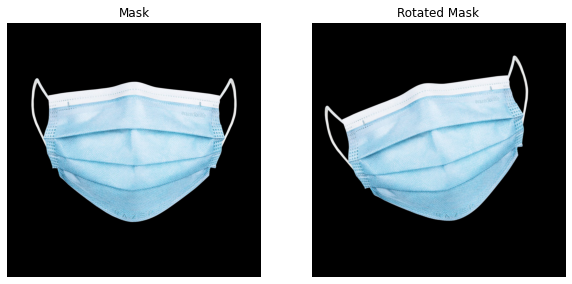

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
center()

# Rotating mask
rotated_mask = rotate_image(blue_mask, angle=15)

axs[0].imshow(blue_mask)
axs[0].set_title("Mask")
axs[0].axis('off')

axs[1].imshow(rotated_mask)
axs[1].set_title("Rotated Mask")
axs[1].axis('off')

plt.show()

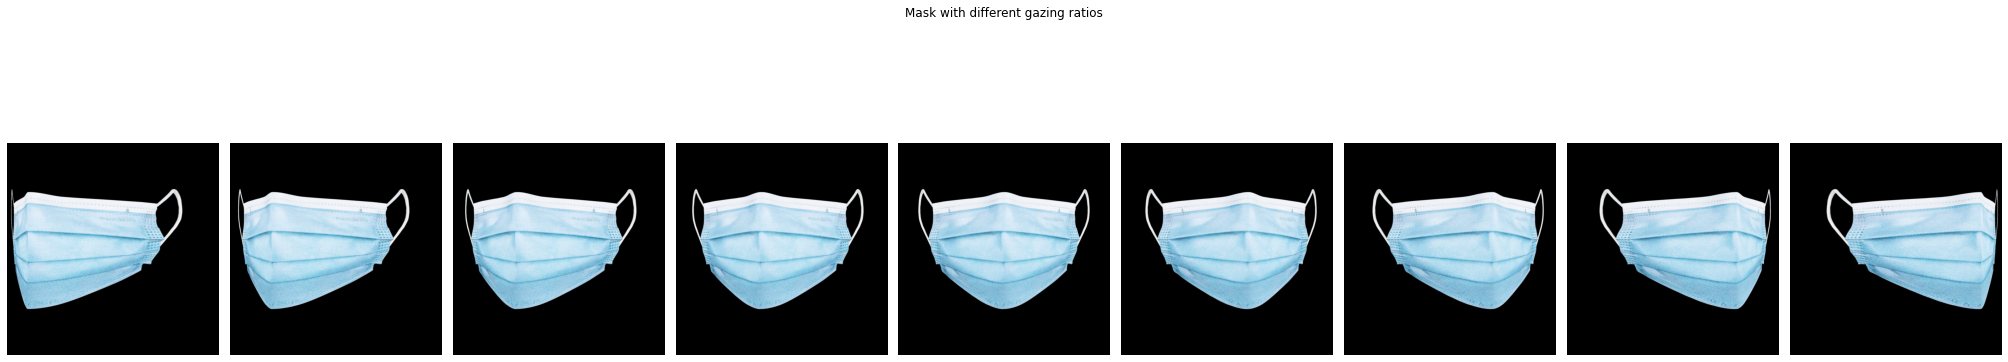

In [41]:
nb_positions = 9
fig, axs = plt.subplots(1, nb_positions, figsize=(28,7))
center()

ratios = np.linspace(0.1,0.9,nb_positions)

for i in range(nb_positions):
  mask_prop, _, _ = proportionize_mask(blue_mask, ratios[i])
  axs[i].imshow(mask_prop)
  axs[i].axis('off')  

plt.suptitle("Mask with different gazing ratios") 
plt.tight_layout()
plt.show() 

### Misplacement of mask

In order to place the mask in an <i>incorrect way</i>, a clear definition of what an incorrectly worn mask has to be stated.
<br>What we consider to be a misplaced mask, for the data augmentation part, is a mask worn under the nose, since this is the most common way people wear their mask incorrectly.
<br>To simulate this, we took into consideration the padding we put in the mask image and the resizing coefficients that we already talked about, to proceed in a way that the mask will be placed just below the nose.

### Placing the mask on the picture

Placing the mask on the picture is not an evident process. It essentially required two steps:
<ul>
<li><b>Getting an appropriate mask picture</b>
<br>When getting a picture of the mask, it is important to have a picture for which, when the mask is rotated, its entirety remains inside said picture.
In order to achive this, we created a mask picture that is square, with the center of the mask being the exact center of the picture. The square being large enough for the mask to be able to rotate freely inside it.
<br>Note that the padding we added to this picture will affect the parameters we have to tune for the size and height coefficients.
<li><b>Overlaying the mask picture on the original image</b>
<br>In order to be able to overlay the mask picture on top of the original picture, we have to calculate a binary thresholding of the mask image (bin_mask), where all the pixels inside the mask are set to 1 (after normalization by 255), and its inverse (bin_mask_inverse). Then, we place the mask on the center that we already computed (midpoint of the top left and bottom right corners). To carry on with the overlaying, it's sufficient to multiply the patch of the image that coincides with the mask with the binary mask inverse and add it to the mask multiplied by the bin_mask (simple binary operations).

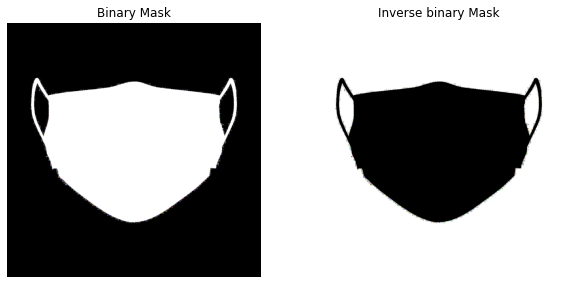

In [42]:
# Visualization of the binary thresholdings

fig, axs = plt.subplots(1, 2, figsize=(10,10))
center()

# Note that we didn't normalize the masks here, since we're computing
# them just for visualization purposes
_,bin_mask = cv2.threshold(blue_mask, 0, 255, cv2.THRESH_BINARY)
bin_mask_inverse = 255 - bin_mask

axs[0].imshow(bin_mask)
axs[0].set_title("Binary Mask")
axs[0].axis('off')

axs[1].imshow(bin_mask_inverse)
axs[1].set_title("Inverse binary Mask")
axs[1].axis('off')

plt.show()

In [77]:
def overlay_mask(img, mask, center_mask=(1,1)):
  """Overlays the mask on the input image at the center center_mask

  Parameters
  ----------
  img : ndarray, shape (H,W)
      The input image.
  mask : ndarray, shape (H_m,W_m)
      The input mask image.
  center_mask : tuple or list
      The point at which to place
      the center of the mask
  Returns
  -------
  overlayed_img : ndarray, shape (H,W)
      The overlayed image.
  """
  overlayed_img = img.copy()

  # Calculating the binary thresholdings of the mask
  _,bin_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
  # Normalzing bin_mask
  bin_mask = bin_mask / 255
  bin_mask_inverse = 1 - bin_mask
  
  mask_height, mask_width,_ = mask.shape
  img_h, img_w, _ = overlayed_img.shape

  # Slicing the input image
  h_min = center_mask[1]-mask_height//2
  h_max = center_mask[1]+mask_height//2
  w_min = center_mask[0]-mask_width//2
  w_max = center_mask[0]+mask_width//2
  indexed_img = overlayed_img[h_min:h_max, w_min:w_max,:]

  # Overlaying the mask
  indexed_img = np.multiply(indexed_img, bin_mask_inverse) + np.multiply(bin_mask, mask)
  overlayed_img[h_min:h_max, w_min:w_max,:] = indexed_img

  return overlayed_img

In [240]:
def wear_mask(img):
  """Places masks incorrectly on the detected faces in img

  Parameters
  ----------
  img : ndarray, shape (H,W)
      The input image.
  Returns
  -------
  img_mask : ndarray, shape (H,W)
      The input image where the faces are wearing
      masks incorrectly
  """
  # Detecting features
  face_detector = MTCNN()
  faces = face_detector.detect_faces(img)
  for face in faces:
    x, y, w, h = face['box']
    keypoints = face['keypoints']

    # Getting the keypoints
    nose = np.array(keypoints['nose'])
    mouth_left = np.array(keypoints['mouth_left'])
    mouth_right = np.array(keypoints['mouth_right'])
    left_eye = np.array(keypoints['left_eye'])
    right_eye = np.array(keypoints['right_eye'])
    forehead = point_on_line(left_eye, right_eye, nose)



    # Determining the size of the mask
    size_coef = 20
    area_ACD = get_area(left_eye, right_eye, nose)
    area_mask = size_coef * area_ACD

    # Getting mask height
    # height_coef is used to account for the black parts in the mask image
    h_mask = get_mask_height(forehead, nose)

    # Getting mask width
    w_mask = area_mask / h_mask

    # Converting to int
    # We need it to be an even number because we're dividing by 2
    h_mask = int(h_mask//2)*2
    w_mask = int(w_mask//2)*2

    # Getting the top left corner of the mask
    top_left_mask, bottom_right_mask = get_mask_coordinates(forehead, nose, w_mask, h_mask)

    # Getting the angle of BD
    rotation_angle = get_angle(forehead, nose)

    # Getting the middle of the mask
    mid_mask = (top_left_mask + bottom_right_mask) // 2

    # gazing_ratio: For when the person is looking away
    gazing_ratio = get_gazing_ratio(left_eye, forehead, right_eye)

    # Adjusting the mask
    blue_mask_prop, w_mask_left, w_mask_right = proportionize_mask(blue_mask, gazing_ratio)

    # Resizing the mask
    resized_mask = resize_mask(blue_mask_prop, w_mask, h_mask)

    # Rotating the mask
    rotated_mask = rotate_image(resized_mask, rotation_angle)

    # Adjusting midmask for gazing ratio
    # The effective gazing ratio measures the amount of the gaze of the face
    # independently of the direction in which the face is gazing
    # It's 0 if no gazing (gazing_ratio=0.5)
    effective_gazing_ratio = np.abs(min(gazing_ratio, 1-gazing_ratio) - 0.5)**2
    # translation_coef: Emprical correction to the translation
    translation_coef = 2.5
    translation_distance = (w_mask_left - w_mask_right)*effective_gazing_ratio
    translation_distance *= translation_coef
    mask_translation = get_mask_translation(forehead, nose, translation_distance)
    mid_mask = mid_mask + mask_translation

    # Giving img its mask
    img_mask = overlay_mask(img, rotated_mask, (mid_mask[0], mid_mask[1]))
    img = img_mask.copy()

  return img_mask


Placing the mask on Zendaya

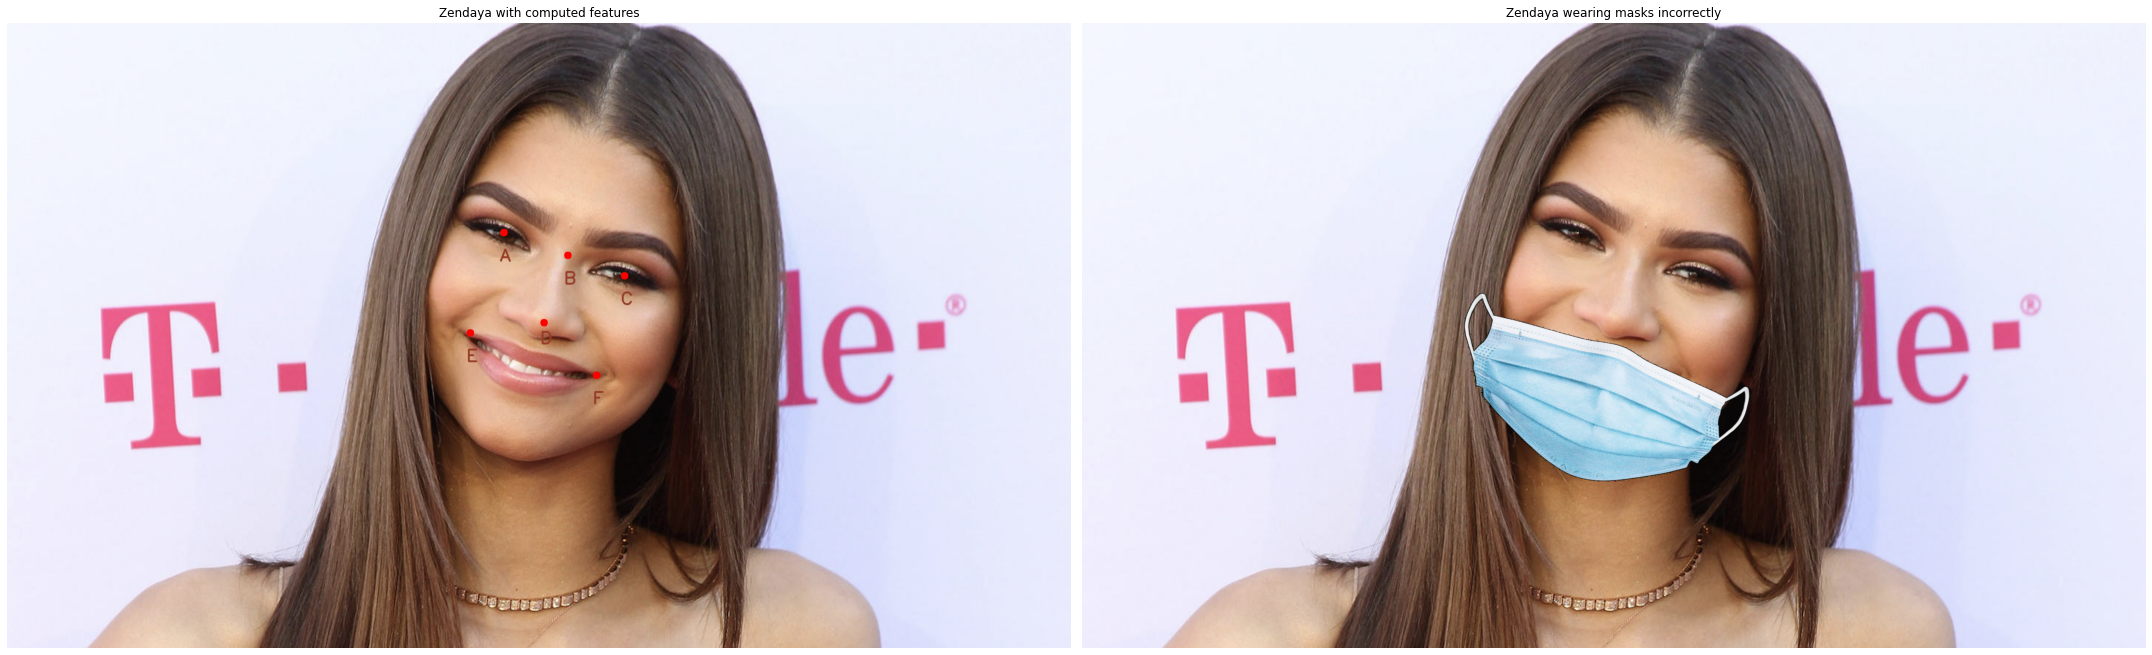

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(30,15))
center()

img_zendaya_mask = wear_mask(img=img_zendaya_intrinsic)

axs[0].imshow(img_zendaya)
axs[0].axis('off')
axs[0].set_title("Zendaya with computed features")

axs[1].imshow(img_zendaya_mask)
axs[1].axis('off')
axs[1].set_title("Zendaya wearing masks incorrectly")

plt.tight_layout()
plt.show()

### Some illustrative examples on Friends characters

#### Single characters

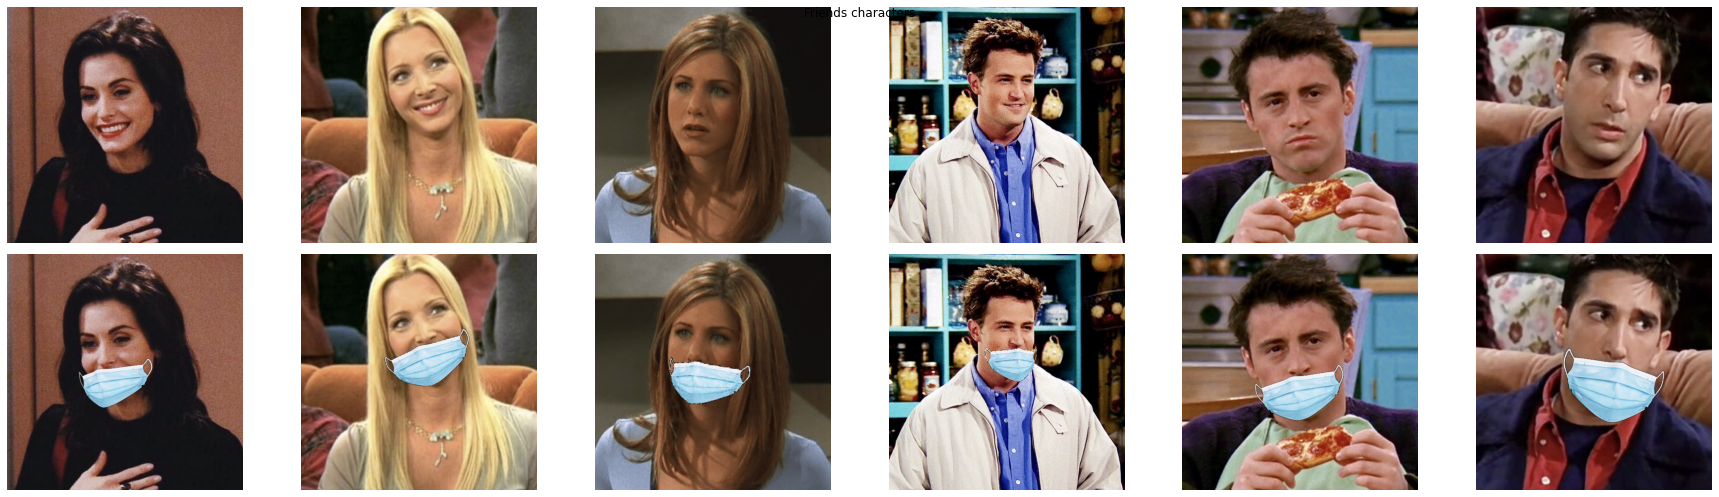

In [213]:
friends_paths = glob.glob('extended_dataset/misplaced/friends_characters*/*')

fig, axs = plt.subplots(2, len(friends_paths), figsize=(25,7))
center()

for i in range(len(friends_paths)):
  friend_img = cv2.imread(friends_paths[i])
  friend_img = cv2.cvtColor(friend_img, cv2.COLOR_BGR2RGB)
  friend_img_mask = wear_mask(img=friend_img)

  axs[0,i].imshow(friend_img)
  axs[0,i].axis('off')
  axs[1,i].imshow(friend_img_mask)
  axs[1,i].axis('off')

plt.suptitle("Friends characters")
plt.tight_layout()
plt.show()

#### Group photo

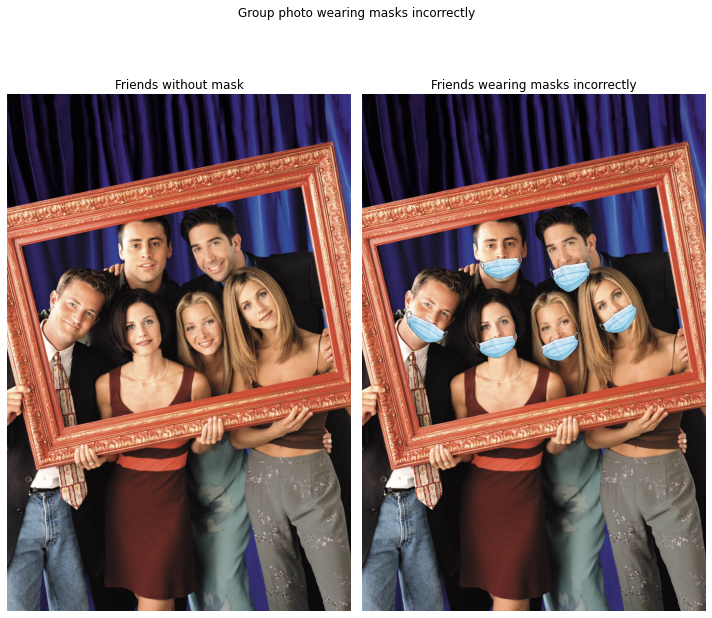

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
center()

group_img = cv2.imread('extended_dataset/misplaced/friends/friends.png')
group_img = cv2.cvtColor(group_img, cv2.COLOR_BGR2RGB)
group_img_mask = wear_mask(img=group_img)

axs[0].imshow(group_img)
axs[0].axis('off')
axs[0].set_title("Friends without mask")

axs[1].imshow(group_img_mask)
axs[1].axis('off')
axs[1].set_title("Friends wearing masks incorrectly")

plt.suptitle("Group photo wearing masks incorrectly")
plt.tight_layout()
plt.show()

#### You can try it yourself!

<IPython.core.display.Javascript object>

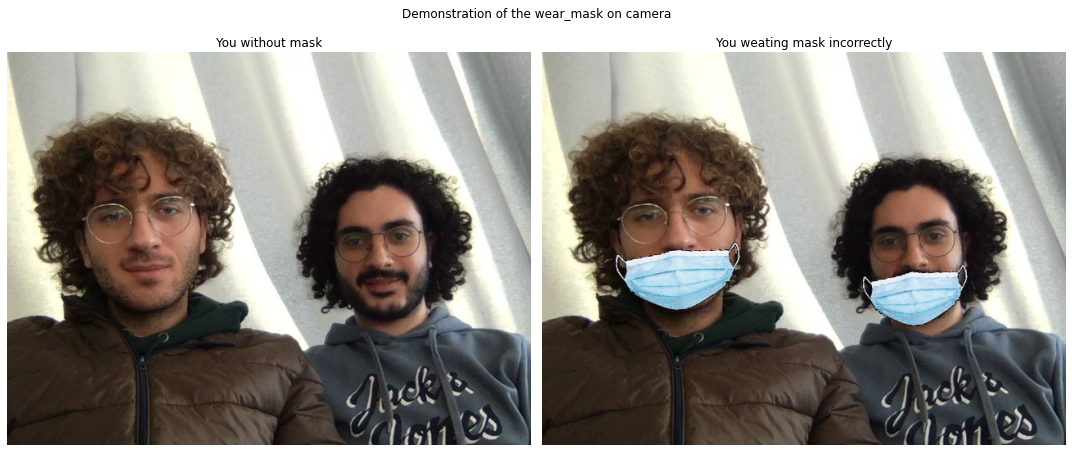

In [239]:
# Taking the picture
you_filename = 'photo.jpg'
img_camera = take_photo(filename=you_filename)

# Reading the image from the drive
img_camera = cv2.imread(you_filename)
img_camera = cv2.cvtColor(img_camera, cv2.COLOR_BGR2RGB)

# Placing the mask incorrectly
img_camera_mask = wear_mask(img=img_camera)

# Plotting the images
fig, axs = plt.subplots(1, 2, figsize=(15,7))
center()

axs[0].imshow(img_camera)
axs[0].axis('off')
axs[0].set_title("You without mask")

axs[1].imshow(img_camera_mask)
axs[1].axis('off')
axs[1].set_title("You weating mask incorrectly")

plt.suptitle("Demonstration of the wear_mask on camera")
plt.tight_layout()
plt.show()

### Loading the faces and adding misplaced masks to them

Now that the process of placing the mask incorrectly over an image is clear, we will apply this to the chunk of the dataset specified for augmenting the misplaced mask class in our dataset.
<br><font color='red'><b>Note:</b></font> To place the mask incorrectly over the faces we can use the wear_mask function that we showed above. However, this function was implemented for visualization purposes. We will code a more compact version of it where we crop the face after placing the mask on it

In [371]:
def get_misplaced_faces(confidence_threshold=0.88, data_paths={}):
  """Gets the faces from data_paths and places masks incorrectly on them

  Parameters
  ----------
  confidence_threshold: float
      The threshold above which the detection is considered.
  data_paths : Dictionary
      Dictionary with the label as the key and the list of paths as the value

  Returns
  -------
  X : ndarray, shape (N,img_size,3)
      List of the detected faces (patches) in RGB
  Y : ndarray, shape (N,nb_classes)
      One hot encoding of the target labels
  """
  # Initialzing face dector
  face_detector = MTCNN()
  X, Y = [], []
  
  # Iterating over the different label groups: Mask and No Mask
  for label, paths in data_paths.items():   
    # Iterating over the scrapped data
    for imagePath in tqdm(paths):
      bgr_image = cv2.imread(imagePath)
      rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
      faces = face_detector.detect_faces(rgb_image)
    

      for face in faces:
        try:
          # Getting the coordinates of the bounding box
          x, y, w, h = face['box']
          confidence = face['confidence']
          keypoints = face['keypoints']
          
          # Skipping the detected faces with low confidence
          if confidence < confidence_threshold:
            continue 

          # Proceeding as in the wear mask function
          # Getting the keypoints
          nose = np.array(keypoints['nose'])
          mouth_left = np.array(keypoints['mouth_left'])
          mouth_right = np.array(keypoints['mouth_right'])
          left_eye = np.array(keypoints['left_eye'])
          right_eye = np.array(keypoints['right_eye'])
          forehead = point_on_line(left_eye, right_eye, nose)

          # Determining the size of the mask
          size_coef = 20
          area_ACD = get_area(left_eye, right_eye, nose)
          area_mask = size_coef * area_ACD

          # Getting mask height
          # height_coef is used to account for the black parts in the mask image
          h_mask = get_mask_height(forehead, nose)

          # Getting mask width
          w_mask = area_mask / h_mask

          # Converting to int
          # We need it to be an even number because we're dividing by 2
          h_mask = int(h_mask//2)*2
          w_mask = int(w_mask//2)*2

          # Getting the top left corner of the mask
          top_left_mask, bottom_right_mask = get_mask_coordinates(forehead, nose, w_mask, h_mask)

          # Getting the angle of BD
          rotation_angle = get_angle(forehead, nose)

          # Getting the middle of the mask
          mid_mask = (top_left_mask + bottom_right_mask) // 2

          # gazing_ratio: For when the person is looking away
          gazing_ratio = get_gazing_ratio(left_eye, forehead, right_eye)

          # Adjusting the mask
          blue_mask_prop, w_mask_left, w_mask_right = proportionize_mask(blue_mask, gazing_ratio)

          # Resizing the mask
          resized_mask = resize_mask(blue_mask_prop, w_mask, h_mask)

          # Rotating the mask
          rotated_mask = rotate_image(resized_mask, rotation_angle)

          # Adjusting midmask for gazing ratio
          # The effective gazing ratio measures the amount of the gaze of the face
          # independently of the direction in which the face is gazing
          # It's 0 if no gazing (gazing_ratio=0.5)
          effective_gazing_ratio = np.abs(min(gazing_ratio, 1-gazing_ratio) - 0.5)**2
          # translation_coef: Emprical correction to the translation
          translation_coef = 2.5
          translation_distance = (w_mask_left - w_mask_right)*effective_gazing_ratio
          translation_distance *= translation_coef
          mask_translation = get_mask_translation(forehead, nose, translation_distance)
          mid_mask = mid_mask + mask_translation

          # Giving img its mask
          img_mask = overlay_mask(rgb_image, rotated_mask, (mid_mask[0], mid_mask[1]))


          # Getting the patch and resizing
          patch_roi =  img_mask[y : y+h, x : x+w]
          img = cv2.resize(patch_roi, img_size)

          # Converting label to one hot encoding
          l = to_categorical(label, num_classes=nb_classes)

          X.append(img)
          Y.append(l)
      
        except Exception as e:
          pass
    
  X, Y = np.array(X), np.array(Y)

  print(f"\n\nX_misplaced shape {X.shape}")
  print(f"Y_misplaced shape {Y.shape}")

  print(f"\nNumber of detected faces from the loaded data: {Y.shape[0]}")
  print(f"Size of each face: {X.shape[1]} x {X.shape[2]} x {X.shape[3]}")
  return X, Y

In [372]:
loaded_misplaced_paths = glob.glob('data_to_add/no_mask_misplaced/*')
loaded_data_paths = {2: loaded_misplaced_paths}
X_misplaced, Y_misplaced = get_misplaced_faces(confidence_threshold=confidence_threshold, data_paths=loaded_data_paths)

100%|██████████| 3281/3281 [1:21:07<00:00,  1.48s/it]



X_misplaced shape (2983, 100, 100, 3)
Y_misplaced shape (2983, 3)

Number of detected faces from the loaded data: 2983
Size of each face: 100 x 100 x 3


In [374]:
# filename_X_misplaced = 'saved_numpy_data/X_misplaced.npy'
# filename_Y_misplaced = 'saved_numpy_data/Y_misplaced.npy'

# np.save(filename_X_misplaced, X_misplaced)
# np.save(filename_Y_misplaced, Y_misplaced)
# a = np.load(filename_X_misplaced)
# b = np.load(filename_Y_misplaced)
# if ((a==X_misplaced).all()) and ((b==Y_misplaced).all()):
#   print("Files saved successfully!!!!!!")

Files saved successfully!!!!!!


In [375]:
# Defining the filenames
filename_X_misplaced = 'saved_numpy_data/X_misplaced.npy'
filename_Y_misplaced = 'saved_numpy_data/Y_misplaced.npy'

The cell below will be run only once

In [ ]:
# # Saving the files
np.save(filename_X_misplaced, X_misplaced)
np.save(filename_Y_misplaced, Y_misplaced)

In [ ]:
# X_misplaced = np.load(filename_X_misplaced)
# Y_misplaced = np.load(filename_Y_misplaced)

### Merging together all the dataset

In [376]:
# Appending the detected faces with no mask
X = np.append(X, X_loaded_no_mask, axis=0)
Y = np.append(Y, Y_loaded_no_mask, axis=0)

# Appending the faces with misplaced masks
X = np.append(X, X_misplaced, axis=0)
Y = np.append(Y, Y_misplaced, axis=0)

y = np.argmax(Y, axis=1)

In [377]:
filename_X = 'saved_numpy_data/X.npy'
filename_Y = 'saved_numpy_data/Y.npy'

np.save(filename_X, X)
np.save(filename_Y, Y)

### Visualizing the class proportions

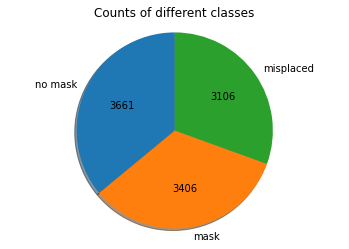

In [378]:
_, class_counts = np.unique(y, axis=0, return_counts=True)

fig1, ax1 = plt.subplots()
center()

labels = list(subtitles.values())
ax1.pie(class_counts, labels=labels, autopct=absolute_value,
        shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title("Counts of different classes")

plt.show()

The dataset is finally ready to be used as an input for our classification model

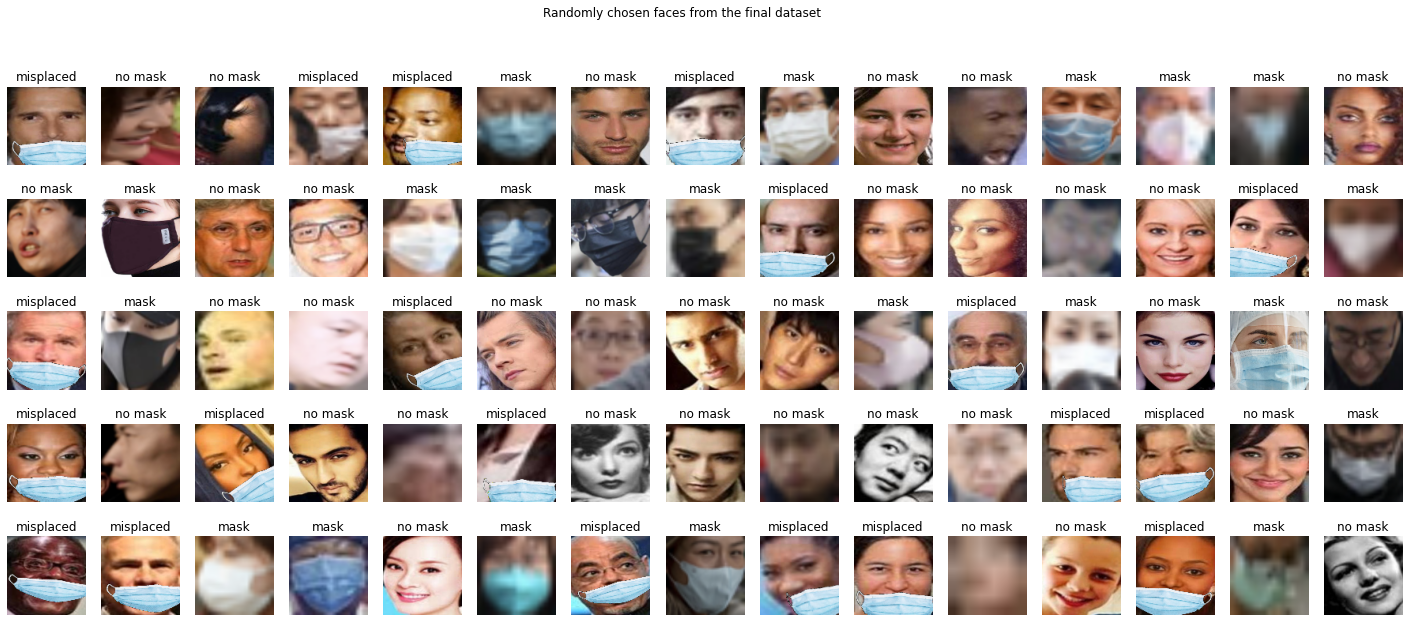

In [380]:
center()
render_size = [5, 15]
figsize = (25,10)

fig, axs = plt.subplots(render_size[0], render_size[1], figsize=figsize)
idx = np.array(random.sample(range(0,X.shape[0]), render_size[0]*render_size[1])).reshape(render_size[0], render_size[1])

for i in range(render_size[0]):
    for j in range(render_size[1]):
        axs[i,j].imshow(X[idx[i,j]])
        axs[i,j].axis('off')
        label = subtitles[np.argmax(Y[idx[i,j]])]
        axs[i,j].set_title(label)


plt.suptitle("Randomly chosen faces from the final dataset")
plt.show()

In [ ]:
# Hases kenet shi mahal w n2aneha hon bel ghalat

We will use the area of the triangle ADC normalized with respect to the whole image to determine the size of the mask.

We will use the axis BD to determine the rotation of the mask.

We will use the traingle EDF to determine the position of the mask.

In [ ]:
# USE DIFFERENT MASKS

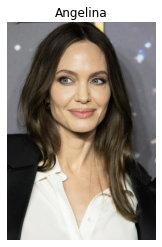

In [ ]:
plt.imshow(angelina)
plt.axis('off')
plt.title("Angelina")
plt.show()